## 0. Import and some functions

In [14]:
import pandas as pd
import numpy as np
import math
import scanpy as sc
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor

## 1. Load data

Load all csv data in database

In [4]:
bulk_counts=pd.read_csv('./bulk_counts.tsv',sep='\t')
singlecell_counts=pd.read_csv('./singlecell_counts.tsv',sep='\t')
true_proportions=pd.read_csv('./true_proportions.tsv',sep='\t')

beta0 = true_proportions.to_numpy(dtype=np.float64) # beta to array


# View the first 5 rows
# singlecell_counts.head()
# bulk_counts.head() # y
true_proportions.head() # beta

,Astrocyte0,Ependymal10,Immune1,Immune8,Neurons4,Neurons5,Neurons7,Oligos3,Oligos6,Vascular11,Vascular2,Vascular9
sample_1,0.100257,0.060708,0.084437,0.137038,0.016808,0.044493,0.054380,0.053787,0.121811,0.085031,0.128930,0.112320
sample_2,0.020145,0.105319,0.063262,0.075808,0.009189,0.046651,0.070507,0.147729,0.152854,0.108676,0.136950,0.062909
sample_3,0.065611,0.114253,0.135423,0.038785,0.124596,0.057531,0.086619,0.015029,0.027473,0.145443,0.068358,0.120879
sample_4,0.160585,0.186341,0.133659,0.097756,0.053659,0.044683,0.002732,0.142244,0.048780,0.031415,0.003317,0.094829
sample_5,0.018659,0.145290,0.064130,0.169565,0.044565,0.085688,0.034783,0.105616,0.083152,0.084601,0.072464,0.091486


## 2. Process data

average cell types, normalization and divide train and test dataset

In [5]:
sc_counts = sc.AnnData(singlecell_counts.T)  # Assuming count_data is your pandas DataFrame
sc.pp.filter_cells(sc_counts, min_counts=900)  # Filter cells with low total counts
sc.pp.filter_genes(sc_counts, min_cells=10)  # Filter genes expressed in fewer cells

# to DataFrame
bulk_counts0 = bulk_counts.loc[sc_counts.var_names,:]
bulk_counts0 = bulk_counts0.to_numpy(dtype=np.float64) # Y to array

gene_expression = sc_counts.X
cell_metadata = sc_counts.obs
df_counts = pd.DataFrame(data=gene_expression, index=sc_counts.obs_names, columns=sc_counts.var_names).T
df_cell_metadata = pd.DataFrame(data=cell_metadata) # total counts
print(f"The shape of scRNA-seq array: {df_counts.shape}")

# for downstream analysis if it is necessary
sc.pp.normalize_total(sc_counts, target_sum=1e4)  # Normalize total counts to a fixed value
sc.pp.log1p(sc_counts)  # Logarithmize the data

The shape of scRNA-seq array: (10310, 2363)


In [77]:
# send cell types and cell names to lists
type_list = true_proportions.columns.values
cell_list = df_counts.columns.values
gene_list = df_counts.index

# Loop through cell type and summarize 'singlecell_counts' to into a gene-by-celltype matrix (use average values)
type_array = np.array([], dtype=np.float64).reshape(len(df_counts), 0)
for type in type_list:
    cols = [i for i in cell_list if type in i]
    type_array = np.hstack([type_array, np.mean(df_counts[cols].to_numpy(dtype=np.float64),axis=1, keepdims=True)])
print(f"The reference profile of cell type - genes is concluded in the matrix with {type_array.shape} dimension.")
# Transfer to database for presentation
type_df = pd.DataFrame(type_array, columns = type_list)
type_df.head()

The reference profile of cell type - genes is concluded in the matrix with (10310, 12) dimension.


,Astrocyte0,Ependymal10,Immune1,Immune8,Neurons4,Neurons5,Neurons7,Oligos3,Oligos6,Vascular11,Vascular2,Vascular9
0,0.445175,0.333333,0.207824,0.261905,0.475806,0.200000,0.087719,343.970845,29.796992,0.230769,0.343902,0.148148
1,0.883772,1.037037,1.036675,1.047619,4.262097,0.983784,1.157895,0.699708,1.345865,0.961538,65.860976,4.703704
2,24.929825,14.259259,3.867971,161.357143,0.161290,0.091892,0.105263,0.416910,2.428571,1.115385,1.590244,31.000000
3,0.508772,1.111111,0.748166,0.619048,86.661290,6.886486,2.228070,2.714286,1.112782,2.384615,1.680488,0.629630
4,45.982456,4.222222,112.154034,23.333333,4.491935,0.681081,1.052632,1.276968,2.834586,3.923077,6.353659,13.703704


In [7]:
# Normalization
type_normal = type_array
bulk_counts0 = bulk_counts0

total_counts = np.sum(bulk_counts0, axis=0) # Y normalization
tpm = (bulk_counts0 / total_counts) * 1e6
bulk_normal = tpm / np.sum(tpm, axis=0) * 1e6

# Attribute variables
X = type_normal
Y = bulk_normal
print(f"The shape of beta array: {beta0.shape}\n")
print(f"The final shape of X array: {X.shape}\n")
print(f"The final shape of Y array: {Y.shape}\n")

print("Check TPM normalization:")
print(np.sum(bulk_normal, axis = 0))

The shape of beta array: (100, 12)

The final shape of X array: (10310, 12)

The final shape of Y array: (10310, 100)

Check TPM normalization:
[1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000.
 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000.
 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000.
 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000.
 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000.
 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000.
 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000.
 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000.
 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000.
 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000.
 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000.
 1000000. 1000000. 1000000. 1000000. 1000000. 1000000

## 3. Build models

### 3.1 Least squares method

OLS, non-negative least squares (NNLS) model, rls, LASSO

In [41]:
# General functions
def reg_sm(reg, X = X, Y = Y, beta0 = beta0): # General model
    reg.fit(X, Y)
    beta = reg.coef_
    if np.any(beta < 0):
        beta = np.where(beta<0, 0, beta)
        print("Proportions in samples have negtive value! They are set to zero.\n")
    beta = beta.T /np.sum(beta, axis=1)
    beta = beta.T

    r2_score0 = r2_score(beta0, beta)
    mse0 = mean_squared_error(beta0, beta)
    mean_pcc = np.mean([np.corrcoef(i0, i)[0, 1] for i0, i in zip(beta0.T, beta.T)])
    print(f"For the model: {reg}")
    print(f"mean_pcc score: {mean_pcc:.4f}")
    print(f"R2 score: {r2_score0:.4f}")
    print(f"MSE: {mse0:.4e}\n")

def reg_mm(reg, X = X, Y = Y, beta0 = beta0): # multi-feature model (MultiOutputRegressor)
    reg.fit(X, Y)
    beta = [i.coef_ for i in reg.estimators_]
    beta = np.vstack(beta)
    if np.any(beta < 0):
        beta = np.where(beta<0, 0, beta)
        print("Proportions in samples have negtive value! They are set to zero.\n")
    beta = beta.T /np.sum(beta, axis=1)
    beta = beta.T

    r2_score0 = r2_score(beta0, beta)
    mse0 = mean_squared_error(beta0, beta)
    mean_pcc = np.mean([np.corrcoef(i0, i)[0, 1] for i0, i in zip(beta0.T, beta.T)])
    print(f"For the model: {reg}")
    print(f"mean_pcc score: {mean_pcc:.4f}")
    print(f"R2 score: {r2_score0:.4f}\n")
    print(f"MSE: {mse0:.4e}\n")

In [31]:
from sklearn.linear_model import LinearRegression

reg_ols = LinearRegression()
reg_sm(reg_ols, X = X, Y = Y)

Proportions in samples have negtive value! They are set to zero.

For the model: LinearRegression()
mean_pcc score: 0.8286
R2 score: 0.4630
MSE: 1.2641e-03



In [32]:
reg_nnls = LinearRegression(positive=True)
reg_sm(reg_nnls, X = X, Y = Y)

For the model: LinearRegression(positive=True)
mean_pcc score: 0.8257
R2 score: 0.4413
MSE: 1.3145e-03



In [38]:
from sklearn.linear_model import MultiTaskLassoCV # Tried MultiOutputRegressor(LassoCV) and Lasso

reg_lassoCV = MultiTaskLassoCV(cv=5, random_state=0)
reg_sm(reg_lassoCV, X = X, Y = Y)

Proportions in samples have negtive value! They are set to zero.

For the model: MultiTaskLassoCV(cv=5, random_state=0)
mean_pcc score: 0.8296
R2 score: 0.5328
MSE: 1.0939e-03



In [39]:
from sklearn.linear_model import ElasticNet # Tried MultiOutputRegressor(ElasticNetCV) and MultiTaskElasticNetCV

reg_els = ElasticNet(alpha = 0.5) # Tried different alpha
reg_sm(reg_els, X = X, Y = Y)

Proportions in samples have negtive value! They are set to zero.

For the model: ElasticNet(alpha=0.5)
mean_pcc score: 0.8195
R2 score: 0.6082
MSE: 9.1298e-04



In [44]:
from sklearn.linear_model import HuberRegressor # tried different epsilon 1, 1.5, 2, default one still better

reg_rls = MultiOutputRegressor(HuberRegressor(epsilon = 1, max_iter=1000))
reg_mm(reg_rls, X = X, Y = Y)

Proportions in samples have negtive value! They are set to zero.

For the model: MultiOutputRegressor(estimator=HuberRegressor(epsilon=1, max_iter=1000))
mean_pcc score: 0.9173
R2 score: 0.7788

MSE: 5.0557e-04



### 3.2 Machine learning method

Random forest, support vector machines (SVM), and neural network

In [47]:
from sklearn.svm import NuSVR
reg_svr = MultiOutputRegressor(NuSVR(nu= 0.75, C= 0.5, kernel = 'linear'))
reg_mm(reg_svr, X = X, Y = Y)

Proportions in samples have negtive value! They are set to zero.

For the model: MultiOutputRegressor(estimator=NuSVR(C=0.5, kernel='linear', nu=0.75))
mean_pcc score: 0.9215
R2 score: 0.8212

MSE: 4.0396e-04



## 4. Dimensionality reduction

### 4.1 feature selection

In [49]:
from sklearn.feature_selection import VarianceThreshold
for t0 in [0.0025, 0.005, 0.015, 0.05, 0.2, 0.5, 2, 5]:
    selector = VarianceThreshold(threshold=t0)
    X0 = selector.fit_transform(X.T).T
    Y0 = selector.transform(Y.T).T
    print(f"threshold = {t0}")
    print(f"The shape of Y array: {Y0.shape}")
    print(f"The shape of X array: {X0.shape}\n")
    reg_svr = MultiOutputRegressor(NuSVR(nu= 0.75, C= 0.5, kernel = 'linear'))
    reg_mm(reg_svr, X = X0, Y = Y0)

threshold = 0.0025
The shape of Y array: (7933, 100)
The shape of X array: (7933, 12)

Proportions in samples have negtive value! They are set to zero.

For the model: MultiOutputRegressor(estimator=NuSVR(C=0.5, kernel='linear', nu=0.75))
mean_pcc score: 0.9207
R2 score: 0.8195

MSE: 4.0802e-04

threshold = 0.005
The shape of Y array: (6267, 100)
The shape of X array: (6267, 12)

Proportions in samples have negtive value! They are set to zero.

For the model: MultiOutputRegressor(estimator=NuSVR(C=0.5, kernel='linear', nu=0.75))
mean_pcc score: 0.9199
R2 score: 0.8181

MSE: 4.1135e-04

threshold = 0.015
The shape of Y array: (3957, 100)
The shape of X array: (3957, 12)

Proportions in samples have negtive value! They are set to zero.

For the model: MultiOutputRegressor(estimator=NuSVR(C=0.5, kernel='linear', nu=0.75))
mean_pcc score: 0.9188
R2 score: 0.8158

MSE: 4.1691e-04

threshold = 0.05
The shape of Y array: (2156, 100)
The shape of X array: (2156, 12)

Proportions in samples hav

In [61]:
data = pd.DataFrame(X.T)
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
for t0 in [0.99, 0.95, 0.90, 0.85, 0.83, 0.80]:
    to_drop= [col for col in upper.columns if any(upper[col] > t0)]
    select_list = [i for i in range(X.shape[0]) if i not in to_drop]
    X0 = X[select_list]
    Y0 = Y[select_list]
    print(f"Covariance threshold = {t0}")
    print(f"The shape of Y array: {Y0.shape}")
    print(f"The shape of X array: {X0.shape}\n")
    reg_svr = MultiOutputRegressor(NuSVR(nu= 0.75, C= 0.5, kernel = 'linear'))
    reg_mm(reg_svr, X = X0, Y = Y0)

Covariance threshold = 0.99
The shape of Y array: (8235, 100)
The shape of X array: (8235, 12)

Proportions in samples have negtive value! They are set to zero.

For the model: MultiOutputRegressor(estimator=NuSVR(C=0.5, kernel='linear', nu=0.75))
mean_pcc score: 0.9193
R2 score: 0.8194

MSE: 4.0743e-04

Covariance threshold = 0.95
The shape of Y array: (3768, 100)
The shape of X array: (3768, 12)

Proportions in samples have negtive value! They are set to zero.

For the model: MultiOutputRegressor(estimator=NuSVR(C=0.5, kernel='linear', nu=0.75))
mean_pcc score: 0.9101
R2 score: 0.7911

MSE: 4.7011e-04

Covariance threshold = 0.9
The shape of Y array: (1289, 100)
The shape of X array: (1289, 12)

Proportions in samples have negtive value! They are set to zero.

For the model: MultiOutputRegressor(estimator=NuSVR(C=0.5, kernel='linear', nu=0.75))
mean_pcc score: 0.8747
R2 score: 0.6837

MSE: 7.2550e-04

Covariance threshold = 0.85
The shape of Y array: (428, 100)
The shape of X array: 

In [51]:
for f0 in ['seurat', 'cell_ranger']:
    for n0 in [8000, 6000, 4000, 2000, 1000, 500, 250, 100]:
        sc.pp.highly_variable_genes(sc_counts, flavor=f0, n_top_genes=n0)  # Identify highly variable genes
        print(f"For the highly variable flavor is '{f0}' and selecting the top {n0} genes:")
        highly_variable_genes = sc_counts.var['highly_variable']
        df_highly_variable_genes = pd.DataFrame(data=highly_variable_genes, index=sc_counts.var_names) # is or not highly variable genes

        df_highly_variable_genes = df_highly_variable_genes[df_highly_variable_genes['highly_variable'] == True]
        gene_list = df_counts.index
        select_list = [i for i, gene in enumerate(gene_list) if gene in df_highly_variable_genes.index] # index of first 10000 highly variable genes
        X0 = X[select_list]
        Y0 = Y[select_list]
        reg_svr = MultiOutputRegressor(NuSVR(nu= 0.75, C= 0.5, kernel = 'linear'))
        reg_mm(reg_svr, X = X0, Y = Y0)

For the highly variable flavor is 'seurat' and selecting the top 8000 genes:
Proportions in samples have negtive value! They are set to zero.

For the model: MultiOutputRegressor(estimator=NuSVR(C=0.5, kernel='linear', nu=0.75))
mean_pcc score: 0.9212
R2 score: 0.8206

MSE: 4.0575e-04

For the highly variable flavor is 'seurat' and selecting the top 6000 genes:
Proportions in samples have negtive value! They are set to zero.

For the model: MultiOutputRegressor(estimator=NuSVR(C=0.5, kernel='linear', nu=0.75))
mean_pcc score: 0.9197
R2 score: 0.8179

MSE: 4.1174e-04

For the highly variable flavor is 'seurat' and selecting the top 4000 genes:
Proportions in samples have negtive value! They are set to zero.

For the model: MultiOutputRegressor(estimator=NuSVR(C=0.5, kernel='linear', nu=0.75))
mean_pcc score: 0.9181
R2 score: 0.8129

MSE: 4.2233e-04

For the highly variable flavor is 'seurat' and selecting the top 2000 genes:
Proportions in samples have negtive value! They are set to zer

## 5. Look into cell types

In [63]:
sc.pp.highly_variable_genes(sc_counts, flavor='cell_ranger', n_top_genes=8000)  # Identify highly variable genes
print(f"For the highly variable flavor is 'cell_ranger' and selecting the top 8000 genes:")
highly_variable_genes = sc_counts.var['highly_variable']
df_highly_variable_genes = pd.DataFrame(data=highly_variable_genes, index=sc_counts.var_names) # is or not highly variable genes

df_highly_variable_genes = df_highly_variable_genes[df_highly_variable_genes['highly_variable'] == True]
gene_list = df_counts.index
select_list = [i for i, gene in enumerate(gene_list) if gene in df_highly_variable_genes.index] # index of first 10000 highly variable genes
X0 = X[select_list]
Y0 = Y[select_list]
reg_svr = MultiOutputRegressor(NuSVR(nu= 0.75, C= 0.5, kernel = 'linear'))
reg_svr.fit(X, Y)
beta = [i.coef_ for i in reg_svr.estimators_]
beta = np.vstack(beta)
if np.any(beta < 0):
    beta = np.where(beta<0, 0, beta)
    print("Proportions in samples have negtive value! They are set to zero.\n")
beta = beta.T /np.sum(beta, axis=1)
beta = beta.T

For the highly variable flavor is 'cell_ranger' and selecting the top 8000 genes:
Proportions in samples have negtive value! They are set to zero.



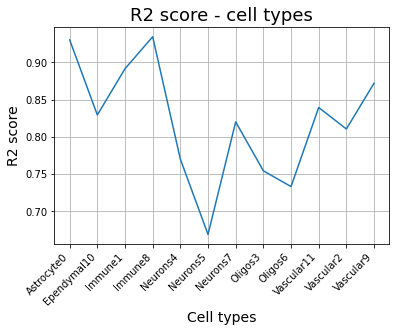

In [75]:
r2_score0 = [r2_score(i0, i) for i0, i in zip(beta0.T, beta.T)]
mse0 = [mean_squared_error(i0, i) for i0, i in zip(beta0.T, beta.T)]
mean_pcc = [np.corrcoef(i0, i)[0, 1] for i0, i in zip(beta0.T, beta.T)]
plt.plot(type_list, r2_score0)
plt.xticks(rotation=45, ha="right")
plt.grid()
plt.title("R2 score - cell types", fontdict = {"size": 18})
plt.xlabel("Cell types", fontdict = {"size": 14})
plt.ylabel("R2 score", fontdict = {"size": 14})
plt.show()


## 6. Big data analysis

In [115]:
reg_ols = LinearRegression()
reg_ols.fit(X, Y)
beta2 = reg_ols.coef_
if np.any(beta2 < 0):
    beta2 = np.where(beta2<0, 0, beta2)
    print("Proportions in samples have negtive value! They are set to zero.\n")
beta2 = beta2.T /np.sum(beta2, axis=1)
beta2 = beta2.T


Proportions in samples have negtive value! They are set to zero.



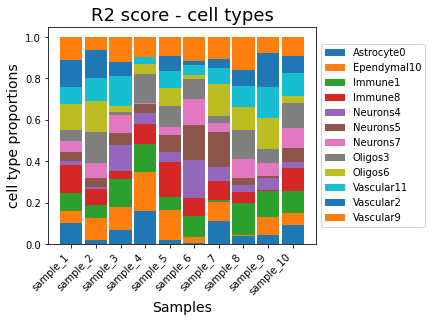

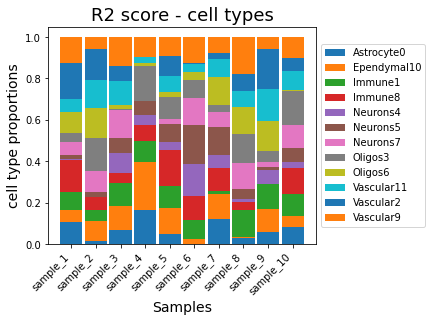

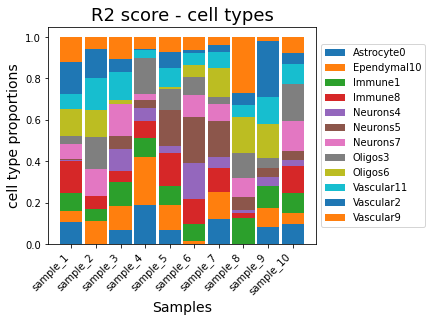

In [116]:
sample_list = true_proportions.index
width = 0.9
n1 = 10
x_list = sample_list[:n1]
weight_counts0 = {ct: beta0[:n1].T[i] for i, ct in enumerate(type_list)}
weight_counts1 = {ct: beta[:n1].T[i] for i, ct in enumerate(type_list)}
weight_counts2 = {ct: beta2[:n1].T[i] for i, ct in enumerate(type_list)}
for weight_counts in [weight_counts0, weight_counts1, weight_counts2]:
    fig, ax = plt.subplots()
    bottom = np.zeros(len(x_list))

    for boolean, weight_count in weight_counts.items():
        p = ax.bar(x_list, weight_count, width, label=boolean, bottom=bottom)
        bottom += weight_count

    ax.set_title("Number of penguins with above average body mass")
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=45, ha="right")
    plt.title("R2 score - cell types", fontdict = {"size": 18})
    plt.xlabel("Samples", fontdict = {"size": 14})
    plt.ylabel("cell type proportions", fontdict = {"size": 14})
    plt.show()